### CONFIGURATION

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [3]:
#CHROM SLICING
minChromFrac = 0#17.443476
maxChromFrac = 26#17.491846

#minChromFrac = 17.689695
#maxChromFrac = 17.73896

In [13]:
# BED FILE
BED_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthSetNew/"
BED_FILE_NAME = "na12878-na24385-somatic-truth-regions.bed"
#GIAB_ID = "NA12878"
#BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
#BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"

# TRUTH SET
SAMPLE_NAMES_TRUTH = {'NA12878':'70-30truth'}
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthSetNew/"
VCF_FILE_NAME_TRUTH = "na12878-na24385-somatic-truth.vcf"
#SAMPLE_NAMES_TRUTH = {'INTEGRATION':'70-30truth'}
#VCF_PATH_TRUTH = BED_PATH
#VCF_FILE_NAME_TRUTH = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.vcf"


# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT11111111"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/161013decoysOnlyRun/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics_snpEff_dbSNP_Cosmicv76.vcf"
SAMPLE_NAMES = {'TUMOR':'varscan'}
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}

#VCF_SAMPLE = GIAB_ID
#VCF_SAMPLE = "12878T"

#VCF_PATH = "/Users/peterpriestley/hmf/analyses/precisionFDA/"
#VCF_FILE_NAME = "160922_GIABDIFF_NA12878_NA12878_NA12878.filtered_variants.vcf"
#VCF_FILE_NAME = "GIABanalysis09-prep1A.filtered_variants.vcf"
#SAMPLE_NAMES = {VCF_SAMPLE:VCF_SAMPLE}

### Functions

In [6]:
def filterByChromFrac(df):
    return df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]

In [7]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] = False
    df['hasFP'] = False
    for columnName in list(df):
        if columnName.endswith('allele'):
            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truth_indelDiff']) \
                    & (~pd.isnull(df['truth_indelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truth_allele']) \
                    & (df['variantType'] == 'SNP'))
            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truth_indelDiff']) \
                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')) |((df[columnName] != df['truth_allele']) \
                    & (df['variantType'] == 'SNP') & (df[columnName] != ''))
    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
    return df

In [8]:
def calcuatePrecisionSensivityMatrix(df):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('_allele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = len(dfTruth[dfTruth['variantType'] == variantType]) 
                falseNegatives = truthSet - truePositives
                if positives > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

<h3> Load VCFs and Prepare DF

In [9]:
## LOAD BED
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
cum_sum =0
for row in bed:
    cum_sum += -int(row[1]) + int(row[2])
print cum_sum

reading BED file
Bed File Loaded
2333895411


In [10]:
## LOAD TRUTH SET VCF
truthBed = copy.deepcopy(bed)
dfTruth = aVCF.loadVaraintsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH, \
                                   SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,True,truthBed)
dfTruth = filterByChromFrac(dfTruth)
dfTruth.rename(columns={'70-30truthallele':'truth_allele','70-30truthindelDiff':'truth_indelDiff','70-30truthindelPos':'truth_indelPos'}, inplace=True)
dfTruth = dfTruth[['chrom','pos','variantType','ref','truth_allele','truth_indelDiff','truth_indelPos']]
dfTruth = dfTruth.set_index(['chrom','pos'])

reading vcf file: na12878-na24385-somatic-truth.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
reading VCF File line: 1100000
Number variants loaded: 1101868


In [14]:
# LOAD SAMPLE VCF + match to truth set
sampleBed = copy.deepcopy(bed)
dfProd = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,False,True,sampleBed)
dfProd = filterByChromFrac(dfProd)
dfProd = dfProd.set_index(['chrom','pos'])
dfProd = calculateTruth(dfProd,dfTruth)

reading vcf file: CPCT11111111R_CPCT11111111T_merged_somatics_snpEff_dbSNP_Cosmicv76.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
reading VCF File line: 1100000
reading VCF File line: 1200000
reading VCF File line: 1300000
reading VCF File line: 1400000
Number variants loaded: 1077641


In [ ]:
#len(dfProd[(dfProd['variantType']== "SNP")&(dfProd['Truth']== True) &(dfProd['Set1GIAB12878QS']<34)&(dfProd['filter']=='MappingQuality')])


In [ ]:
#len(dfProd[(dfProd['Truth']== True) &(dfProd['filter'].str.contains("VarMapQual|RefMapQual|VarDist3|VarAvgRL|VarBaseQual|RefBaseQual|VarReadPos"))])

In [ ]:
#dfProd[(dfProd['filter']!= "PASS")].head(10)

In [ ]:
#len(dfProd[(dfProd['Truth']== False) & (dfProd['variantType']== "SNP")])

In [ ]:
#dfTemp = dfProd[((dfProd['filter']== "PASS")|(dfProd['filter']== "SnpCluster")|(dfProd['filter']== "MappingQuality"))&(dfProd.variantType == 'INDEL')&(dfProd['Truth']== False)&(dfProd['hasTP']== True)]

<h3> SLICE ANALYSIS

In [ ]:
# SLICE SETTINGS
#SLICE_VCF_PATH = "/Users/peterpriestley/hmf/70-30slice/"
#SLICE_VCF_FILE_NAME = "somatics.merged.vcf"
#SLICE_SAMPLE_NAMES = SAMPLE_NAMES 

In [ ]:
#sliceBed = copy.deepcopy(bed)

In [ ]:
#dfSlice = aVCF.loadVaraintsFromVCF(SLICE_VCF_PATH,SLICE_VCF_FILE_NAME,SLICE_SAMPLE_NAMES,VCF_SAMPLE,True,True,sliceBed)
#dfSlice = filterByChromFrac(dfSlice)
#dfSlice = dfSlice.set_index(['chrom','pos'])
#dfSlice = calculateTruth(dfSlice,dfTruth)

In [ ]:
#dfSlice[(dfSlice['Truth']== False)].head(10)

### PRECISION + SENSITIVITY|

In [15]:
#PRECISION + SENSITIVITY by caller - PROD
outputDF = calcuatePrecisionSensivityMatrix(dfProd)
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,96385,64381,539,32004,0.9917,0.6680
1,INDEL,strelka,96385,48290,275,48095,0.9943,0.5010
3,INDEL,varscan,96385,63756,633,32629,0.9902,0.6615
5,SNP,freebayes,1005483,933778,916,71705,0.9990,0.9287
4,SNP,mutect,1005483,930684,5735,74799,0.9939,0.9256
0,SNP,strelka,1005483,939492,3360,65991,0.9964,0.9344
2,SNP,varscan,1005483,900857,1112,104626,0.9988,0.8959


In [16]:
dfTemp = dfProd[(dfProd['filter']== "PASS")|(dfProd['filter']== "SnpCluster")|(dfProd['filter']== "MappingQuality")]
outputDF = calcuatePrecisionSensivityMatrix(dfTemp)
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,96385,58196,217,38189,0.9963,0.6038
1,INDEL,strelka,96385,48290,275,48095,0.9943,0.5010
3,INDEL,varscan,96385,63687,617,32698,0.9904,0.6608
5,SNP,freebayes,1005483,927531,390,77952,0.9996,0.9225
4,SNP,mutect,1005483,930684,5735,74799,0.9939,0.9256
0,SNP,strelka,1005483,939492,3360,65991,0.9964,0.9344
2,SNP,varscan,1005483,900747,632,104736,0.9993,0.8958


In [ ]:
dfTemp = dfProd[(dfProd['filter']== "PASS")]
outputDF = calcuatePrecisionSensivityMatrix(dfTemp)
outputDF

In [24]:
dftemp = dfProd[(dfProd['variantType']== "INDEL")].reset_index()
pd.pivot_table(dftemp, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

Truth,False,True
numCallers,,
1,933,12549
2,212,17751
3,30,42792


In [17]:
dftemp = dfProd[(dfProd['variantType']== "SNP")].reset_index()
pd.pivot_table(dftemp, values='pos', index=['vennSegment'], columns=['Truth'], aggfunc='count')

Truth,False,True
vennSegment,,
FilteredInAll,569,127
Intersection,75,829105
filterInvarscan-freebayes,88,606
filterInvarscan-freebayes-mutect,4,296
filterInvarscan-mutect,17,46
freebayes,443,5866
freebayes-mutect,20,10290
mutect,4181,9189
strelka,1714,4371


In [ ]:
dfProd[(dfProd['variantType']== "INDEL")&(dfProd['Truth']== True)&(dfProd['filter']== "PASS")].head(10)

In [ ]:
#PRECISION + SENSITIVITY by caller - SLICE
outputDF = calcuatePrecisionSensivityMatrix(dfSlice)
outputDF

# False Negative Analysis

In [ ]:
pd.options.display.max_rows = 200
caller = "varscan"
dfProd[(dfProd.Truth == True) &(dfProd[caller+'allele'] != '') & (dfProd.variantType == 'INDEL')][['ref',caller+'indelDiff',caller+'QS',caller+'AF','numCallers']]

In [ ]:
dfSlice[(dfSlice['Truth'] == True) & (dfSlice['freebayesallele'] != '') & (dfSlice.variantType == 'INDEL')]

In [ ]:
unfilteredBed = copy.deepcopy(bed)

In [ ]:
# SETTINGS
myCaller = 'varscan'
UNFILTERED_VCF_PATH = "/Users/peterpriestley/hmf/70-30slice/"
if myCaller == 'varscan':
    UNFILTERED_VCF_FILE_NAME = "varscan.snp.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'freebayes':
    UNFILTERED_VCF_FILE_NAME = "freebayes.somatic.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}  
elif myCaller == 'strelka':
    UNFILTERED_VCF_FILE_NAME = "/strelka/results/all.somatic.snvs.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'mutect':
    UNFILTERED_VCF_FILE_NAME = "mutect.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}


dfUnfiltered = aVCF.loadVaraintsFromVCF(UNFILTERED_VCF_PATH,UNFILTERED_VCF_FILE_NAME,UNFILTERED_SAMPLE_NAMES,VCF_SAMPLE,False,True,unfilteredBed)
dfUnfiltered['Truth']=dfUnfiltered.chromPos.isin(dfTruth['chromPos']) 
dfUnfiltered = dfUnfiltered[(dfUnfiltered.chromFrac > minChromFrac)&(dfUnfiltered.chromFrac < maxChromFrac)]

In [ ]:
dfTruth['inUnfiltered'+myCaller]=dfTruth.chromPos.isin(dfUnfiltered[dfUnfiltered[myCaller+'allele'] != '']['chromPos'])
dfTruth['inSlice']=dfTruth.chromPos.isin(dfSlice['chromPos'])

In [ ]:
#False Positives - pre-somatic
dfTruth[['inSlice','pos','inUnfiltered'+myCaller,'variantType']].groupby(['variantType','inUnfiltered'+myCaller]).agg('count')


In [ ]:
dfUnfiltered['inSlice'+myCaller]=dfUnfiltered.chromPos.isin(dfSlice[dfSlice[myCaller+'allele'] != '']['chromPos'])
dfUnfiltered['inSlice']=dfUnfiltered.chromPos.isin(dfSlice['chromPos'])

In [ ]:
dfUnfiltered[['inSlice'+myCaller,'pos','Truth','variantType','filter']].groupby(['variantType','inSlice'+myCaller,'Truth','filter']).agg('count')


In [ ]:

dfUnfiltered[(dfUnfiltered['Truth'] == True)&
            (dfUnfiltered['inSlice'+myCaller] == True)& 
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'PETE')]['pos']

In [ ]:
#FALSE NEGATIVES IN UNFILTERED
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == False)& 
             (dfUnfiltered[myCaller+'somaticGT'] != '2')&
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'str10')].sort_values([myCaller+'QS'],ascending=False)

In [ ]:
dfSlice[dfSlice.pos>'37577400'].head(10)

In [ ]:
#FALSE POSITIVES`
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == True) & (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['Truth'] == False)].sort_values([myCaller+'QS'],ascending=False)

<h3> SNP

In [18]:
snpdf = dfProd[(dfProd.variantType == 'SNP')]

In [ ]:
snpdf[['Truth','pos']].groupby(['Truth']).agg('count')

In [ ]:
pd.pivot_table(snpdf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [ ]:
indeldf= dfProd[(dfProd.variantType == 'INDEL')]

In [ ]:
pd.pivot_table(indeldf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Read Depth

In [ ]:
for columnName in list(df):
    if columnName.endswith('allelicFreq'):
        df[df[columnName] != ''].hist(column=columnName,by="Truth",bins=40,figsize=(10,5))
        

In [ ]:
df[df.freebayesreadDepth != ''].hist(column="freebayesallelicFreq",by="Truth",bins=30)

In [ ]:
# INDELS BY CALLER BY TRUTH
caller = 'freebayes'
truths = indeldf.Truth.unique()
for truth in truths:
    ser = indeldf[(indeldf.Truth == truth) &(indeldf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" INDEL "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+" Qual Score CDF - INDELS",figsize=[15,6], xlim=[0,100],ylim=[0,1])

truths = snpdf.Truth.unique()
for truth in truths:
    ser = snpdf[(snpdf.Truth == truth) &(snpdf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" SNP "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+"Qual Score CDF",figsize=[15,6],xlim=[0,100],ylim=[0,1])

<h3> Allelic Depth

KeyError: 'truth_AF'

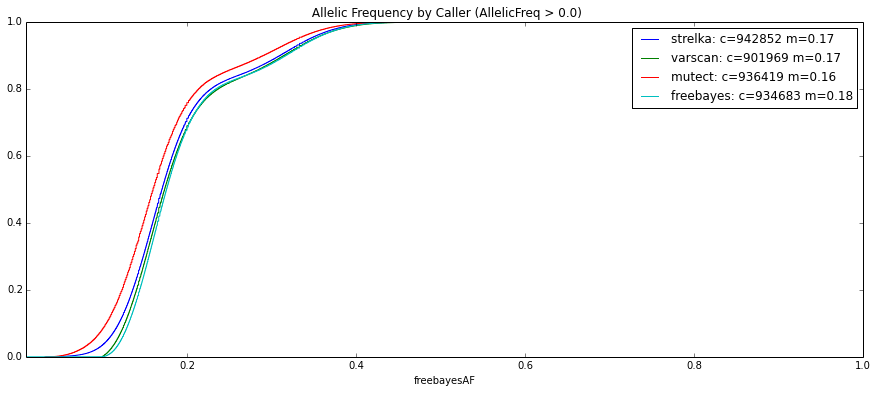

In [19]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6])

In [ ]:
# BY CALLER BY TRUTH
truths = snpdf.Truth.unique()
for truth in truths:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.Truth == truth) &(snpdf[columnName] != '')][columnName[:-6] + 'allelicFreq']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller and Truth",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''